### Some test cases to see how parameter estimation works

\begin{equation}
V(r) = - 4r \int_0^{\infty} F(K) \frac{J_2(Kr)}{K} dK
\end{equation}

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.special as sp
%matplotlib inline

#### Consider two profiles of F (K) 
 
a) F(K) = sin(K)  
b) F(K) = exp(-K^2)

In [68]:
Kfine = np.logspace(-1, 3, 1001) 

Klin = np.linspace(1e-1, 1e3, 101)
Klog = np.logspace(-1, 3, 101)
dKlin = np.diff(Klin)
dKlog = np.diff(Klog)
Klin_ax = 0.5*(Klin[0:-1] + Klin[1:])
Klog_ax = 0.5*(Klog[0:-1] + Klog[1:])

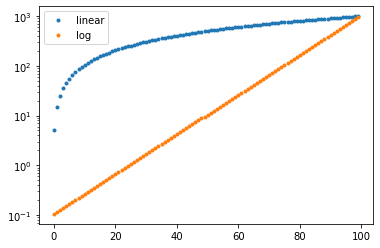

In [69]:
plt.plot(Klin_ax, '.', label='linear')
plt.plot(Klog_ax,'.', label='log')

plt.yscale('log')
plt.legend()

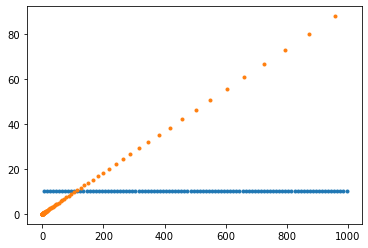

In [70]:
plt.plot(Klin_ax, dKlin, '.')
plt.plot(Klog_ax, dKlog, '.')

In [487]:
# Create a set of articifial functions
epsu = 2 # units of energy that go upscale
a=.1 # units of energy input
b=1.5
c= 0.25

epsj_lin = a* np.exp( - (np.log10(Klin_ax) - b)**2 / 2/c**2)
epsj_log = a* np.exp( - (np.log10(Klog_ax) - b)**2 / 2/c**2)
# normalize to ensure constant flux

#epsj_ling = a*epsj_ling #/ sum(epsj_test*dk_f)

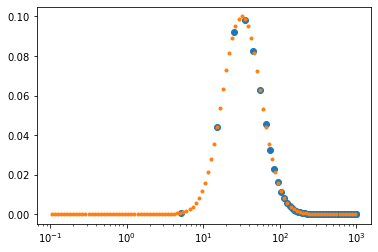

In [488]:
plt.plot(Klin_ax, epsj_lin, 'o')
plt.plot(Klog_ax, epsj_log, '.')

plt.xscale('log')

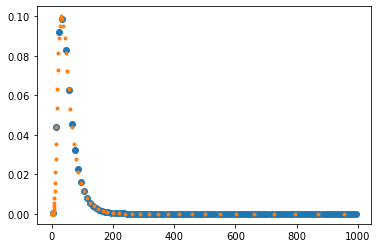

In [489]:
plt.plot(Klin_ax, epsj_lin, 'o')
plt.plot(Klog_ax, epsj_log, '.')

#plt.xscale('log')

In [490]:
# The total energy injection, defined as area under curve.
np.sum(epsj_log*dKlog), np.sum(epsj_lin*dKlin)

(5.381390950653072, 5.385741972160384)

In [491]:
Hlog = np.zeros((len(Kfine), len(Klog_ax)))
Hlin = np.zeros((len(Kfine), len(Klin_ax)))

for i in range(len(Klog_ax)):
    Hlog[:, i] = np.heaviside(Kfine - Klog_ax[i], 0.5)

for i in range(len(Klin_ax)):
    Hlin[:, i] = np.heaviside(Kfine - Klin_ax[i], 0.5)    

In [492]:
Flog = -epsu + np.matmul(Hlog, epsj_log*dKlog)
Flin = -epsu + np.matmul(Hlin, epsj_lin*dKlin)

Text(0, 0.5, 'F (k)')

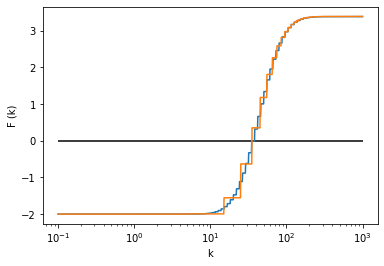

In [493]:
plt.plot(Kfine, Flog)
plt.plot(Kfine, Flin)

plt.hlines(0, min(Kfine), max(Kfine), color='k')
plt.xscale('log')
plt.xlabel('k')
plt.ylabel('F (k)')

Appropriate multiplication by the dk ensures that the choice of the axis will not impact on the estimates of the functions. 

#### Estimate the correspoding V 

In [494]:
rlog = np.logspace(-3, 0, 25 )

Text(0, 0.5, 'r')

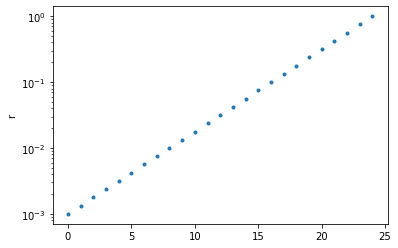

In [495]:
plt.plot(rlog, '.')
plt.yscale('log')
plt.ylabel('r')

In [496]:
def make_Amat(K, r, dK):
    # Generate an A matrix,
    # given r and k (k are points that are used to parameterize F)
    
    Nk = len(K) # could use Klin too
    Nr = len(r)
    A = np.zeros((Nr, Nk+1))

    A[:,0] = 2*r

    for i in range(Nr): # rows
        for j in range(Nk): # columns
            A[i,j+1] = -4 * sp.jv(1, K[j]*r[i])/ K[j] * dK[j]
            
    return A
        

In [497]:
A = make_Amat(Klog_ax, rlog, dKlog)

/Users/dhruvbalwada/code/miniconda/envs/sogos/lib/python3.7/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  """Entry point for launching an IPython kernel.


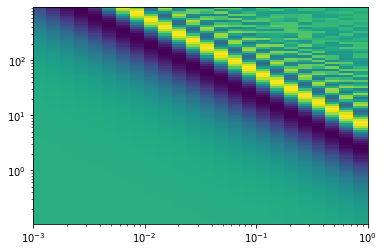

In [498]:
plt.pcolormesh(rlog, Klog_ax, A[:,1:].T)
plt.xscale('log')
plt.yscale('log')

In [499]:
eps_param = np.concatenate(([epsu] , epsj_log))

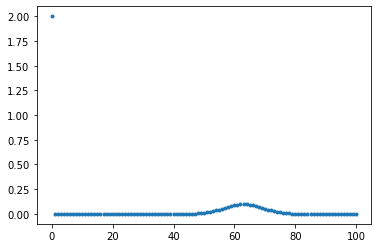

In [500]:
plt.plot(eps_param, '.')

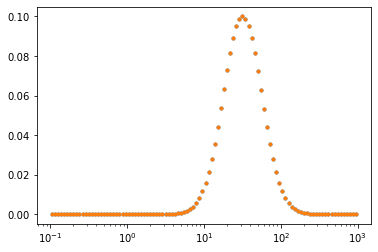

In [501]:
plt.plot(Klog_ax, eps_param[1:], '.')
plt.plot(Klog_ax, epsj_log, '.')

plt.xscale('log')

In [502]:
eps_param.shape

(101,)

In [503]:
V_log = np.matmul(A, eps_param)

In [504]:
V_log.shape

(25,)

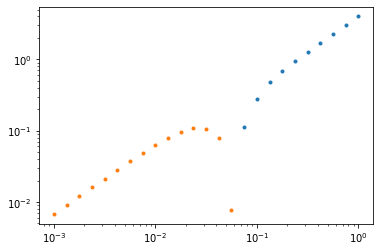

In [505]:
plt.plot(rlog, (V_log), '.')
plt.plot(rlog, -(V_log), '.')
plt.xscale('log')
plt.yscale('log')

In [506]:
# inversion
eps_invert = np.dot(np.linalg.pinv(A), V_log)

# note that one problem is that there are 101 unknowns, but only 25 equations 
# (number of V points). 

In [507]:
eps_invert.shape

(101,)

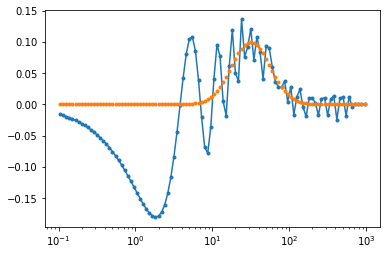

In [508]:
plt.plot(Klog_ax, eps_invert[1:], '.-')
plt.plot(Klog_ax, eps_param[1:], '.')
plt.xscale('log')

In [509]:
Kinv = np.logspace( np.log10(1/np.max(rlog)), np.log10(1/np.min(rlog)), 21) 
#Kinv= Klog
# keep smaller than size of r to make sure more equations than values. 
# lose resolution this way.
dKinv = np.diff(Kinv)
Kinv_ax = 0.5*(Kinv[0:-1] + Kinv[1:])

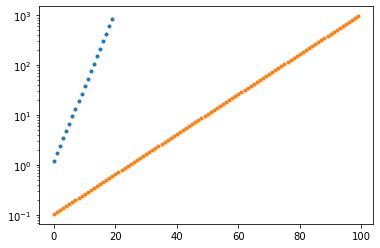

In [510]:
plt.plot(Kinv_ax, '.')
plt.plot(Klog_ax, '.')

plt.yscale('log')

In [511]:
Asmall = make_Amat(Kinv_ax, rlog, dKinv)

In [512]:
Asmall.shape

(25, 21)

In [513]:
eps_invert_small = np.dot(np.linalg.pinv(Asmall), V_log)


In [514]:
eps_invert_small[0], eps_param[0]

(172990.23876953125, 2.0)

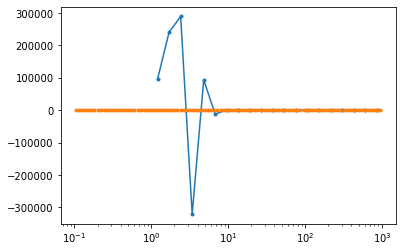

In [515]:
plt.plot(Kinv_ax, eps_invert_small[1:], '.-')
plt.plot(Klog_ax, eps_param[1:], '.')
plt.xscale('log')

In [516]:
Asmall.shape

(25, 21)

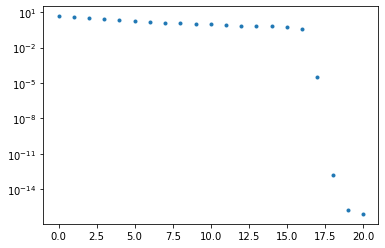

In [517]:
U, A_SVD, Vh = np.linalg.svd(Asmall)
plt.plot(A_SVD, '.')
plt.yscale('log')

The above blow up is resulting not from any noise in the estimates, but rather from the difference in where the r points and k points are chosen. 


#### Regularization

To account for differences in r and k axis points. This will always be the case in the real world, because nature does not have any specified grid points. 

In [518]:
I = np.eye(len(Kinv_ax)+1) # get's appended below A
I[0,:] = 0 #If we don't want to use epsilon_u for regularization

for i in range(len(Kinv_ax)):
    I[i+1, i+1] = 1 #dKinv[i] # try to weight by the dk 
    
I.shape

(21, 21)

In [519]:
O = np.zeros((len(Kinv_ax)+1,)) # gets appended below y

In [520]:
lam = 1.9
#mu = 1.5

# Append the extra matrices, and then solve as simple least squares
A_tik = np.concatenate((Asmall, lam*I)) 
y_tik = np.concatenate((V_log,  O))

In [586]:
Asmall.shape, I.shape

((25, 21), (21, 21))

In [521]:
x_tik = np.dot(np.linalg.pinv(A_tik), y_tik)

In [522]:
x_tik[0], eps_param[0]

(2.007455058570763, 2.0)

(-0.01, 0.15)

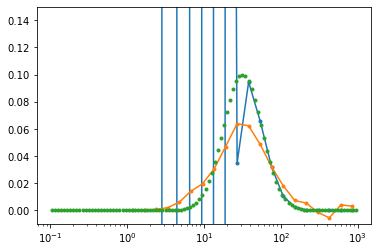

In [523]:
plt.plot(Kinv_ax, eps_invert_small[1:], '.-')
plt.plot(Kinv_ax, x_tik[1:], '.-')
plt.plot(Klog_ax, eps_param[1:], '.')
plt.xscale('log')

plt.ylim([-0.01, 0.15])

#### Noisy estimates of V. 

We saw above that that differences in grid points are sufficient to lead to blow up in inversion. This was easily fixed with some regularization. 
Now we add more realism by thinking about the case where V(r) are not known precisely, but rather with some error. 


In [552]:
eps = .4
Nsamps = 100

V_err = V_log + eps*rlog*np.random.randn(Nsamps, Nr)

In [553]:
V_err.shape

(100, 25)

Text(0, 0.5, 'V(r)')

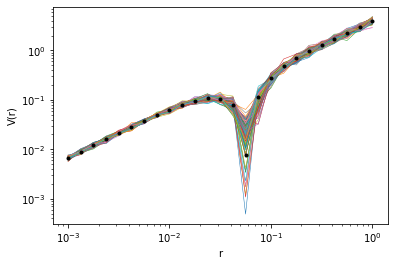

In [562]:

plt.plot(rlog, abs(V_err).T, label='No noise', linewidth=.5);
plt.plot(rlog, abs(V_log), '.', label='No noise', linewidth=2, color='k')
plt.xscale('log')
plt.yscale('log')
#plt.legend()
plt.xlabel('r')
plt.ylabel('V(r)')

In [555]:
x_tik_err = np.zeros((Nsamps, Asmall.shape[1]))

lam = 1.5
#mu = 1.5

# Append the extra matrices, and then solve as simple least squares
A_tik = np.concatenate((Asmall, lam*I))

for i in range(Nsamps):
    y_tik_err = np.concatenate((V_err[i,:], O))
    x_tik_err[i,:] = np.dot(np.linalg.pinv(A_tik), y_tik_err)

In [558]:
V_err.shape

(100, 25)

In [557]:
Asmall.shape

(25, 21)

(-0.01, 0.15)

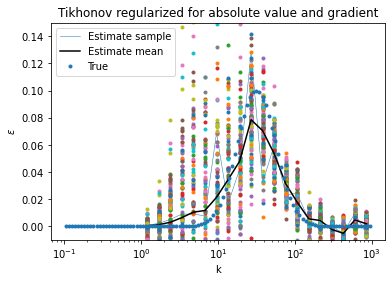

In [584]:
plt.plot(Kinv_ax, (x_tik_err[0,1:]).T, linewidth=.5, label='Estimate sample')
plt.plot(Kinv_ax, (x_tik_err[:,1:]).T, '.', linewidth=.5)
plt.plot(Kinv_ax,  np.mean((x_tik_err[:,1:]).T,1), linewidth=1.5, color = 'k' , label='Estimate mean')
plt.plot(Klog_ax, eps_param[1:], '.', color='tab:blue', label= 'True')
plt.xscale('log')
plt.legend()
plt.ylabel(r'$\epsilon$')
plt.xlabel('k')
plt.title('Tikhonov regularized for absolute value and gradient')
plt.ylim([-0.01, 0.15])

In [579]:
np.mean(x_tik_err[:,0])

2.0243485496719957

In [559]:
V_reconstruct=np.zeros((Nsamps, Asmall.shape[0])) 

for i in range(Nsamps):
    V_reconstruct[i,:] = np.dot(Asmall, x_tik_err[i,:])

Text(0, 0.5, 'V(r)')

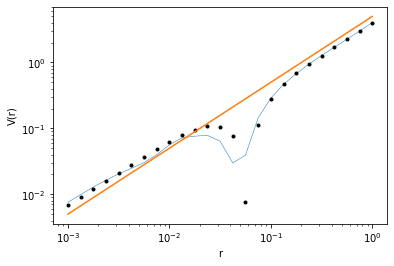

In [583]:
#plt.plot(rlog, abs(V_reconstruct).T, label='No noise', linewidth=.5);
plt.plot(rlog, np.mean(abs(V_reconstruct),0), label='No noise', linewidth=.5);
plt.plot(rlog, abs(V_log), '.', label='No noise', linewidth=2, color='k')

plt.plot(rlog, 5*rlog)
plt.xscale('log')
plt.yscale('log')
#plt.legend()
plt.xlabel('r')
plt.ylabel('V(r)')

In [566]:
from scipy.optimize import nnls

In [567]:
x_nnls = np.zeros((Nsamps, Asmall.shape[1]))

for i in range(Nsamps):
    x_nnls[i,:], res = nnls(Asmall, V_err[i,:])

In [575]:
Kinv_ax.shape

(20,)

In [578]:
np.mean(x_nnls[:,0]) 

2.459069362283275

Text(0.5, 1.0, 'Constrained to be positive')

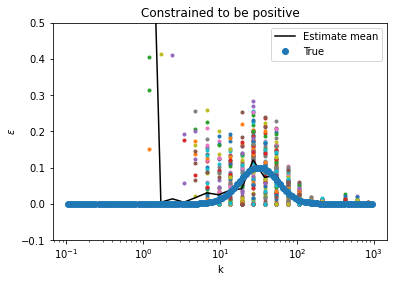

In [577]:
#plt.plot(Kinv_ax, (x_nnls[0,1:]).T, '.', linewidth=.5, label='Estimate sample')
plt.plot(Kinv_ax, (x_nnls[:,1:]).T, '.', linewidth=.5);
plt.plot(Kinv_ax, np.mean((x_nnls[:,1:]).T,1), linewidth=1.5, color = 'k' , label='Estimate mean')
plt.plot(Klog_ax, eps_param[1:], 'o', label='True', color='Tab:blue')
plt.xscale('log')
plt.legend()
plt.ylim([-.1, .5])
plt.ylabel(r'$\epsilon$')
plt.xlabel('k')
plt.title('Constrained to be positive')